# Turku Public Transport Analysis

This notebook explores passenger counts for Turku's bus system in 2024.

---

Note: as I learned half-way into the project, Turku bus system has been overhauled entirely in July 2025.
When data from 2025 appears, I am planning to do some comparisons to the old system.


# Load and Prepare Data

We start by loading the passenger trip data and stop metadata.  
The `load_clean_data` function loads the CSV file with trips data and JSON file with stops data, merges them and fills missing stop names with a placeholder.



In [96]:
from pathlib import Path
import sys

PROJECT_DIR = Path(".").resolve().parent 
DATA_DIR = PROJECT_DIR / "data"
SCRIPTS_DIR = PROJECT_DIR / "scripts"



import sys
sys.path.append(str(SCRIPTS_DIR))

from load_and_merge import load_clean_data

ext_data_2024, data_2024, stops, missing_stops_2024 = load_clean_data(
    DATA_DIR / "2024-foli.csv",
    DATA_DIR / "stops.json"
)

import pandas as pd
import numpy as np

# Basic Overview

Let's have a look at the dataset structure and missing data.


In [97]:
print(ext_data_2024.head())
print(ext_data_2024.info())
print(f"Missing stops: {missing_stops_2024}")

        date line  stop  count      stop_name  stop_lat  stop_lon zone_id  \
0 2024-01-02   99   778      5  Pansion koulu  60.44966  22.16755    FÖLI   
1 2024-01-02   99  1708      5      Katariina  60.41308  22.28881    FÖLI   
2 2024-01-02   99  1494      5      Sävelkuja  60.41913  22.30184    FÖLI   
3 2024-01-02   99   888      5  Kraatarinkatu  60.44665  22.35355    FÖLI   
4 2024-01-02   99   840      5      Jaaninoja  60.44630  22.32770    FÖLI   

     stop_timezone stop_name_filled  
0  Europe/Helsinki    Pansion koulu  
1  Europe/Helsinki        Katariina  
2  Europe/Helsinki        Sävelkuja  
3  Europe/Helsinki    Kraatarinkatu  
4  Europe/Helsinki        Jaaninoja  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773470 entries, 0 to 773469
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              773470 non-null  datetime64[ns]
 1   line              773470 non

Let's calculate the total number of passenger trips recorded in 2024.


In [98]:
total_passengers = ext_data_2024['count'].sum()
print(f"The total number of trips in 2024: {total_passengers :,}")

The total number of trips in 2024: 24,807,995


We see that around 25 million trips were recorded in 2024.

Let's check which days are represented in the dataset.




In [99]:
print(f"Years represented: {ext_data_2024['date'].dt.year.unique()}")
print(f"Number of different dates represented: {ext_data_2024['date'].nunique()}")
print(f"Earliest date: {ext_data_2024['date'].min().date()}")
print(f"Latest date: {ext_data_2024['date'].max().date()}")


Years represented: [2024]
Number of different dates represented: 365
Earliest date: 2024-01-02
Latest date: 2024-12-31


We see that all the represented dates are indeed in 2024, and the data covers the whole year except for Jan. 1st (2024 was a leap year). Since Jan. 1st data is not present, we omit it from the consideration.

Let's now look at the ridership per day and identify busiest and quietest days, according to the data.

In [100]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()

busiest_day = pass_by_date.idxmax().date()
quietest_day = pass_by_date.idxmin().date()

busiest_day_count = pass_by_date.max()
quietest_day_count = pass_by_date.min()

avg_rid = pass_by_date.mean().round(2)

print(f"The biggest amount of rides was recorded on {busiest_day}, with {busiest_day_count} rides.")
print(f"The smallest amount of rides was recorded on {quietest_day}, with {quietest_day_count} rides.")
print(f"The average ridership in 2024 is {avg_rid}.")

The biggest amount of rides was recorded on 2024-11-22, with 110532 rides.
The smallest amount of rides was recorded on 2024-12-31, with 242 rides.
The average ridership in 2024 is 67967.11.


The data from Dec. 31 looks incomplete, since the amount of recorded rides is too small (even for New Year's Eve).

Let's check five busiest and five quietest days, according to the data.

In [101]:
pass_top =  pass_by_date.sort_values(ascending=False).head()
pass_top_reset = pass_top.reset_index()
pass_top_reset.columns = ['Date', 'Rides']
print("Five busiest days:")
display(pass_top_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))



Five busiest days:


Date,Rides
2024-11-22,"110,532"
2024-12-13,"108,655"
2024-12-05,"108,030"
2024-12-04,"107,210"
2024-11-29,"106,735"


In [102]:
pass_bottom =  pass_by_date.sort_values(ascending=True).head()
pass_bottom_reset = pass_bottom.reset_index()
pass_bottom_reset.columns = ['Date', 'Rides']
print("Five quietest days:")
display(pass_bottom_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))

Five quietest days:


Date,Rides
2024-12-31,242
2024-12-25,"9,875"
2024-12-24,"19,794"
2024-06-22,"20,232"
2024-06-23,"21,143"


Dec. 25th has much less rides than the other days (except Dec. 31rd), but since that's Christmas, it looks reasonable.


# Ridership per day of the week

Let's now analyze the ridership on different days of the week. We will start by adding two columns which say what the day of the week is and whether it is workday or weekend.

In [103]:
import numpy as np
ext_data_2024['day'] = ext_data_2024['date'].dt.day_name()
ext_data_2024['day_type'] = np.where(ext_data_2024['day'].isin(['Saturday', 'Sunday']), 'Weekend', 'Workday')


Let's look at the total ridership per day of the week.

In [104]:
pass_per_day = ext_data_2024.groupby('day')['count'].sum()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pass_per_day_sorted = pass_per_day.reindex(days_order)
pass_per_day_sorted = pass_per_day_sorted.reset_index()
pass_per_day_sorted.columns = ['Day of the week', 'Rides in 2024']
print("Total ridership in 2024 per day of the week:")
display(pass_per_day_sorted.style.hide(axis="index").format({
    "Rides in 2024": "{:,}"
}))


Total ridership in 2024 per day of the week:


Day of the week,Rides in 2024
Monday,"4,028,209"
Tuesday,"4,212,021"
Wednesday,"4,177,462"
Thursday,"4,187,958"
Friday,"4,200,810"
Saturday,"2,501,052"
Sunday,"1,500,483"


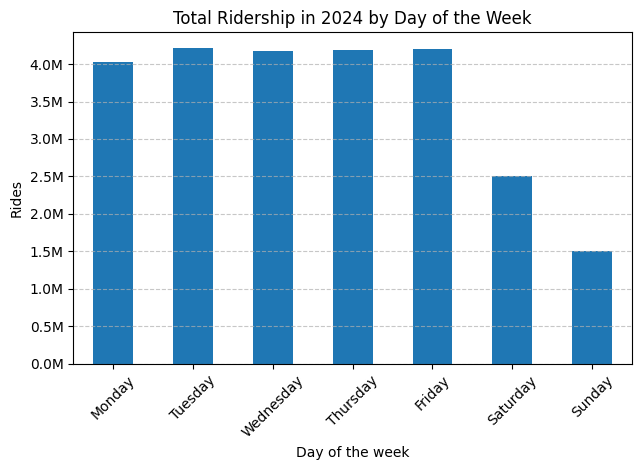

In [105]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


pass_per_day_sorted.plot(kind='bar', x='Day of the week', y='Rides in 2024', legend=False)
plt.title('Total Ridership in 2024 by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}M')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Let's now look at average ridership per day of the week and on workdays vs weekends.

In [106]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['day'] = pass_by_date_df['date'].dt.day_name()

In [107]:
avg_per_day = pass_by_date_df.groupby('day')['count'].mean().round(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_per_day_sorted = avg_per_day.reindex(days_order)
avg_per_day_sorted = avg_per_day_sorted.reset_index()
avg_per_day_sorted.columns = ['Day of the week', 'Average number of rides']
print("Average ridership in 2024 per day of the week:")
display(avg_per_day_sorted.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 


Average ridership in 2024 per day of the week:


Day of the week,Average number of rides
Monday,"77,466"
Tuesday,"79,472"
Wednesday,"80,336"
Thursday,"80,538"
Friday,"80,785"
Saturday,"48,097"
Sunday,"28,855"


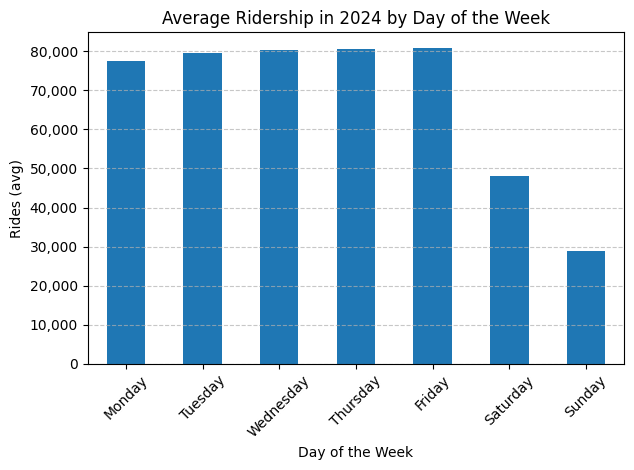

In [108]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


avg_per_day_sorted.plot(kind='bar', x='Day of the week', y='Average number of rides', legend=False)
plt.title('Average Ridership in 2024 by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Rides (avg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Ridership on weekdays vs weekends

Let us also compare average ridership on weekdays and weekends, as well as the average over all days.

In [109]:
pass_by_date_df['day_type'] = np.where(pass_by_date_df['day'].isin(['Saturday', 'Sunday']), 'Weekend day', 'Weekday')
avg_per_day_type = pass_by_date_df.groupby('day_type')['count'].mean().round(0)
avg_per_day_type = avg_per_day_type.reset_index()
avg_per_day_type.columns = ['Day type', 'Average number of rides']

avg_pass = pass_by_date_df['count'].mean().round(0)
avg_pass_df = pd.DataFrame({'Day type': ['All days'], 'Average number of rides': [avg_pass]})
avg_per_day_type = pd.concat([avg_per_day_type, avg_pass_df])

print("Average ridership in 2024 on weekend days (Sat-Sun) vs weekdays (Mon-Fri):")
display(avg_per_day_type.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 


Average ridership in 2024 on weekend days (Sat-Sun) vs weekdays (Mon-Fri):


Day type,Average number of rides
Weekday,"79,718"
Weekend day,"38,476"
All days,"67,967"


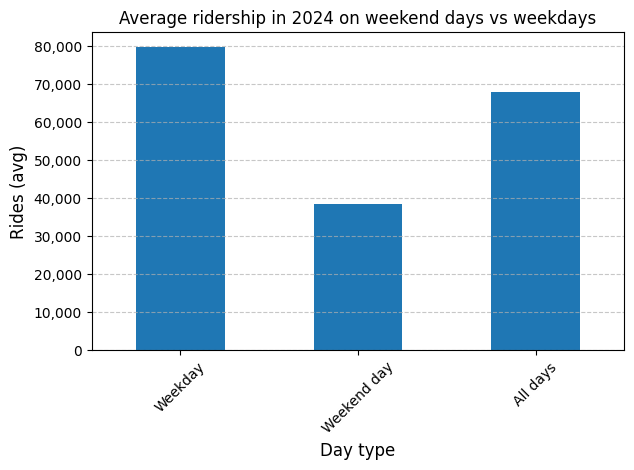

In [110]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


avg_per_day_type.plot(kind='bar', x='Day type', y='Average number of rides', legend=False)
plt.title('Average ridership in 2024 on weekend days vs weekdays')
plt.xlabel('Day type', fontsize=12)
plt.ylabel('Rides (avg)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Let's now look at ridership on public holidays.

In [111]:
import holidays
finland_holidays = holidays.Finland(years=2024)

pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()

pass_by_date_df['is_holiday'] = pass_by_date_df['date'].isin(finland_holidays)
data_by_holiday = pass_by_date_df.groupby('is_holiday')['count'].mean().round(0)

holiday_df = data_by_holiday.reset_index()
holiday_df.columns = ['Day type', 'Average number of rides']

holiday_df['Day type'] = holiday_df['Day type'].map({True: 'Holiday', False: 'Non-holiday'})
display(holiday_df.style.hide(axis='index').format({
    'Average number of rides': '{:,.0f}'
}))




C:\Users\Александр\AppData\Local\Temp\ipykernel_18428\2725929066.py:7: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



Day type,Average number of rides
Non-holiday,"69,511"
Holiday,"29,263"


# Taking public holidays into account

Now we will compare ridership on regular weekdays, Saturdays, Sundays and holidays.

In [112]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['day'] = pass_by_date_df['date'].dt.day_name()
holiday_dates = set(finland_holidays.keys())
pass_by_date_df['is_holiday'] = pass_by_date_df['date'].dt.date.isin(holiday_dates)

import numpy as np
conditions = [pass_by_date_df['is_holiday'],
              pass_by_date_df['day'] == 'Saturday',
              pass_by_date_df['day'] == 'Sunday']
choices = ['Holiday', 'Saturday (not holiday)', 'Sunday (not holiday)']
pass_by_date_df['day_type'] = np.select(conditions, choices, default='Workday')



In [113]:
avg_per_day_type = pass_by_date_df.groupby('day_type')['count'].mean().round(0)
avg_per_day_type = avg_per_day_type.reset_index()
avg_per_day_type.columns = ['Day type', 'Average number of rides']

avg_pass = pass_by_date_df['count'].mean().round(0)
avg_pass_df = pd.DataFrame({'Day type': ['All days'], 'Average number of rides': [avg_pass]})
avg_per_day_type = pd.concat([avg_per_day_type, avg_pass_df])

print("Average ridership in 2024 by day type:")
display(avg_per_day_type.style.hide(axis="index").format({
    "Average number of rides": "{:,.0f}"
})) 

Average ridership in 2024 by day type:


Day type,Average number of rides
Holiday,"29,263"
Saturday (not holiday),"48,916"
Sunday (not holiday),"28,925"
Workday,"81,568"
All days,"67,967"


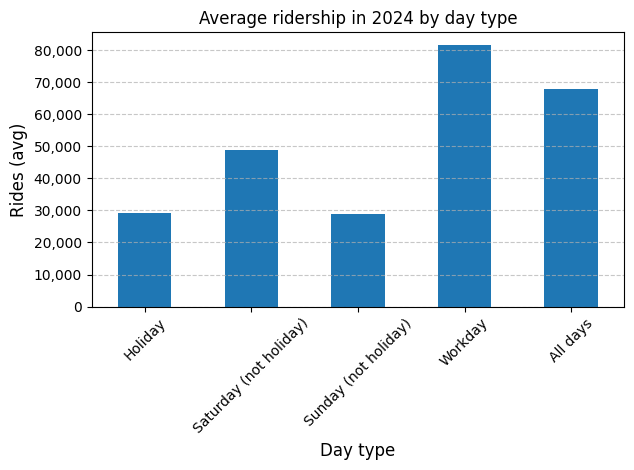

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

avg_per_day_type.plot(kind='bar', x='Day type', y='Average number of rides', legend=False)
plt.title('Average ridership in 2024 by day type')
plt.xlabel('Day type', fontsize=12)
plt.ylabel('Rides (avg)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Ridership trends throughout the year

Let's now analyze how ridership varies in different months and seasons.

In [115]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['month'] = pass_by_date_df['date'].dt.month_name()
avg_by_month = pass_by_date_df.groupby('month')['count'].mean().round(0)
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
avg_by_month = avg_by_month.reindex(months_order)

avg_by_month = avg_by_month.reset_index()
avg_by_month.columns = ['Month', 'Number of day rides (avg)']

print("Average day ridership in 2024 by month:")
display(avg_by_month.style.hide(axis="index").format({
    "Number of day rides (avg)": "{:,.0f}"
})) 

Average day ridership in 2024 by month:


Month,Number of day rides (avg)
January,"77,240"
February,"71,193"
March,"76,352"
April,"74,400"
May,"65,077"
June,"48,960"
July,"48,822"
August,"62,176"
September,"69,724"
October,"73,581"


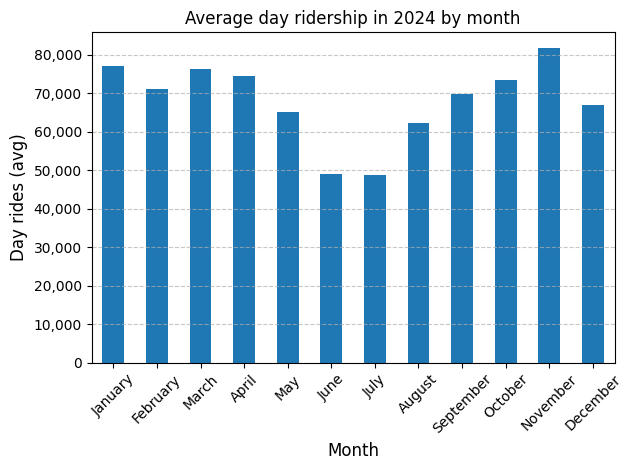

In [116]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

avg_by_month.plot(kind='bar', x='Month', y='Number of day rides (avg)', legend=False)
plt.title('Average day ridership in 2024 by month')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Day rides (avg)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.show()

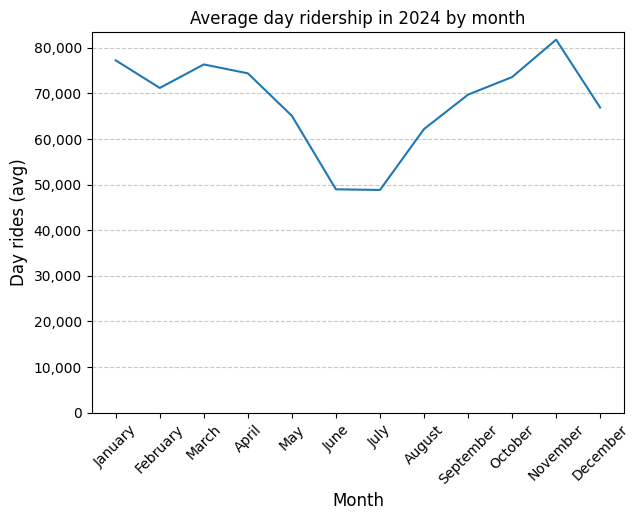

In [117]:
avg_by_month.plot(kind='line', x='Month', y='Number of day rides (avg)', legend=False)
plt.title('Average day ridership in 2024 by month')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Day rides (avg)', fontsize=12)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.xticks(ticks=range(len(avg_by_month)), labels=avg_by_month['Month'], rotation=45)
plt.show()

In [118]:
pass_by_date = ext_data_2024.groupby('date')['count'].sum()
pass_by_date_df = pass_by_date.reset_index()
pass_by_date_df['month'] = pass_by_date_df['date'].dt.month_name()
conditions = [pass_by_date_df['month'].isin(['December', 'January', 'February']),
              pass_by_date_df['month'].isin(['March', 'April', 'May']),
              pass_by_date_df['month'].isin(['June', 'July', 'August']),
              pass_by_date_df['month'].isin(['September', 'October', 'November'])]
choices = ['Winter', 'Spring', 'Summer', 'Autumn']
pass_by_date_df['season'] = np.select(conditions, choices, default='Unknown')

avg_by_season = pass_by_date_df.groupby('season')['count'].mean().round(0)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
avg_by_season = avg_by_season.reindex(season_order)

avg_by_season = avg_by_season.reset_index()

avg_by_season.columns = ['Season', 'Number of day rides (avg)']

print("Average day ridership in 2024 by season:")
display(avg_by_season.style.hide(axis="index").format({
    "Number of day rides (avg)": "{:,.0f}"
})) 


Average day ridership in 2024 by season:


Season,Number of day rides (avg)
Winter,"71,731"
Spring,"71,917"
Summer,"53,367"
Autumn,"75,013"


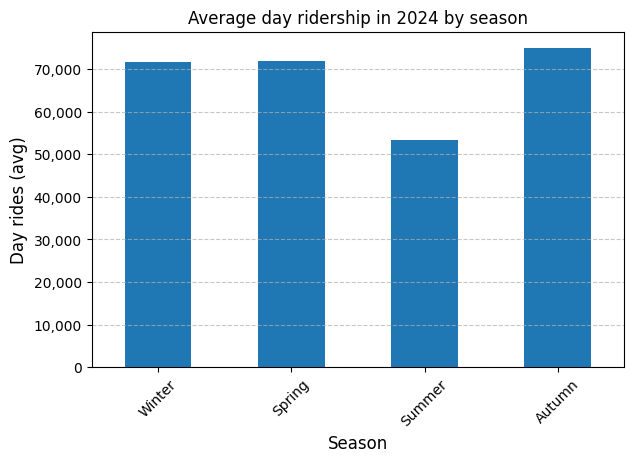

In [119]:
avg_by_season.plot(kind='bar', x='Season', y='Number of day rides (avg)', legend=False)
plt.title('Average day ridership in 2024 by season')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Day rides (avg)', fontsize=12)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.xticks(ticks=range(len(avg_by_season)), labels=avg_by_season['Season'], rotation=45)
plt.show()

# Heatmap

We now have a look at a heatmap over days of the week and weeks.

C:\Users\Александр\AppData\Local\Temp\ipykernel_18428\1539005222.py:28: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



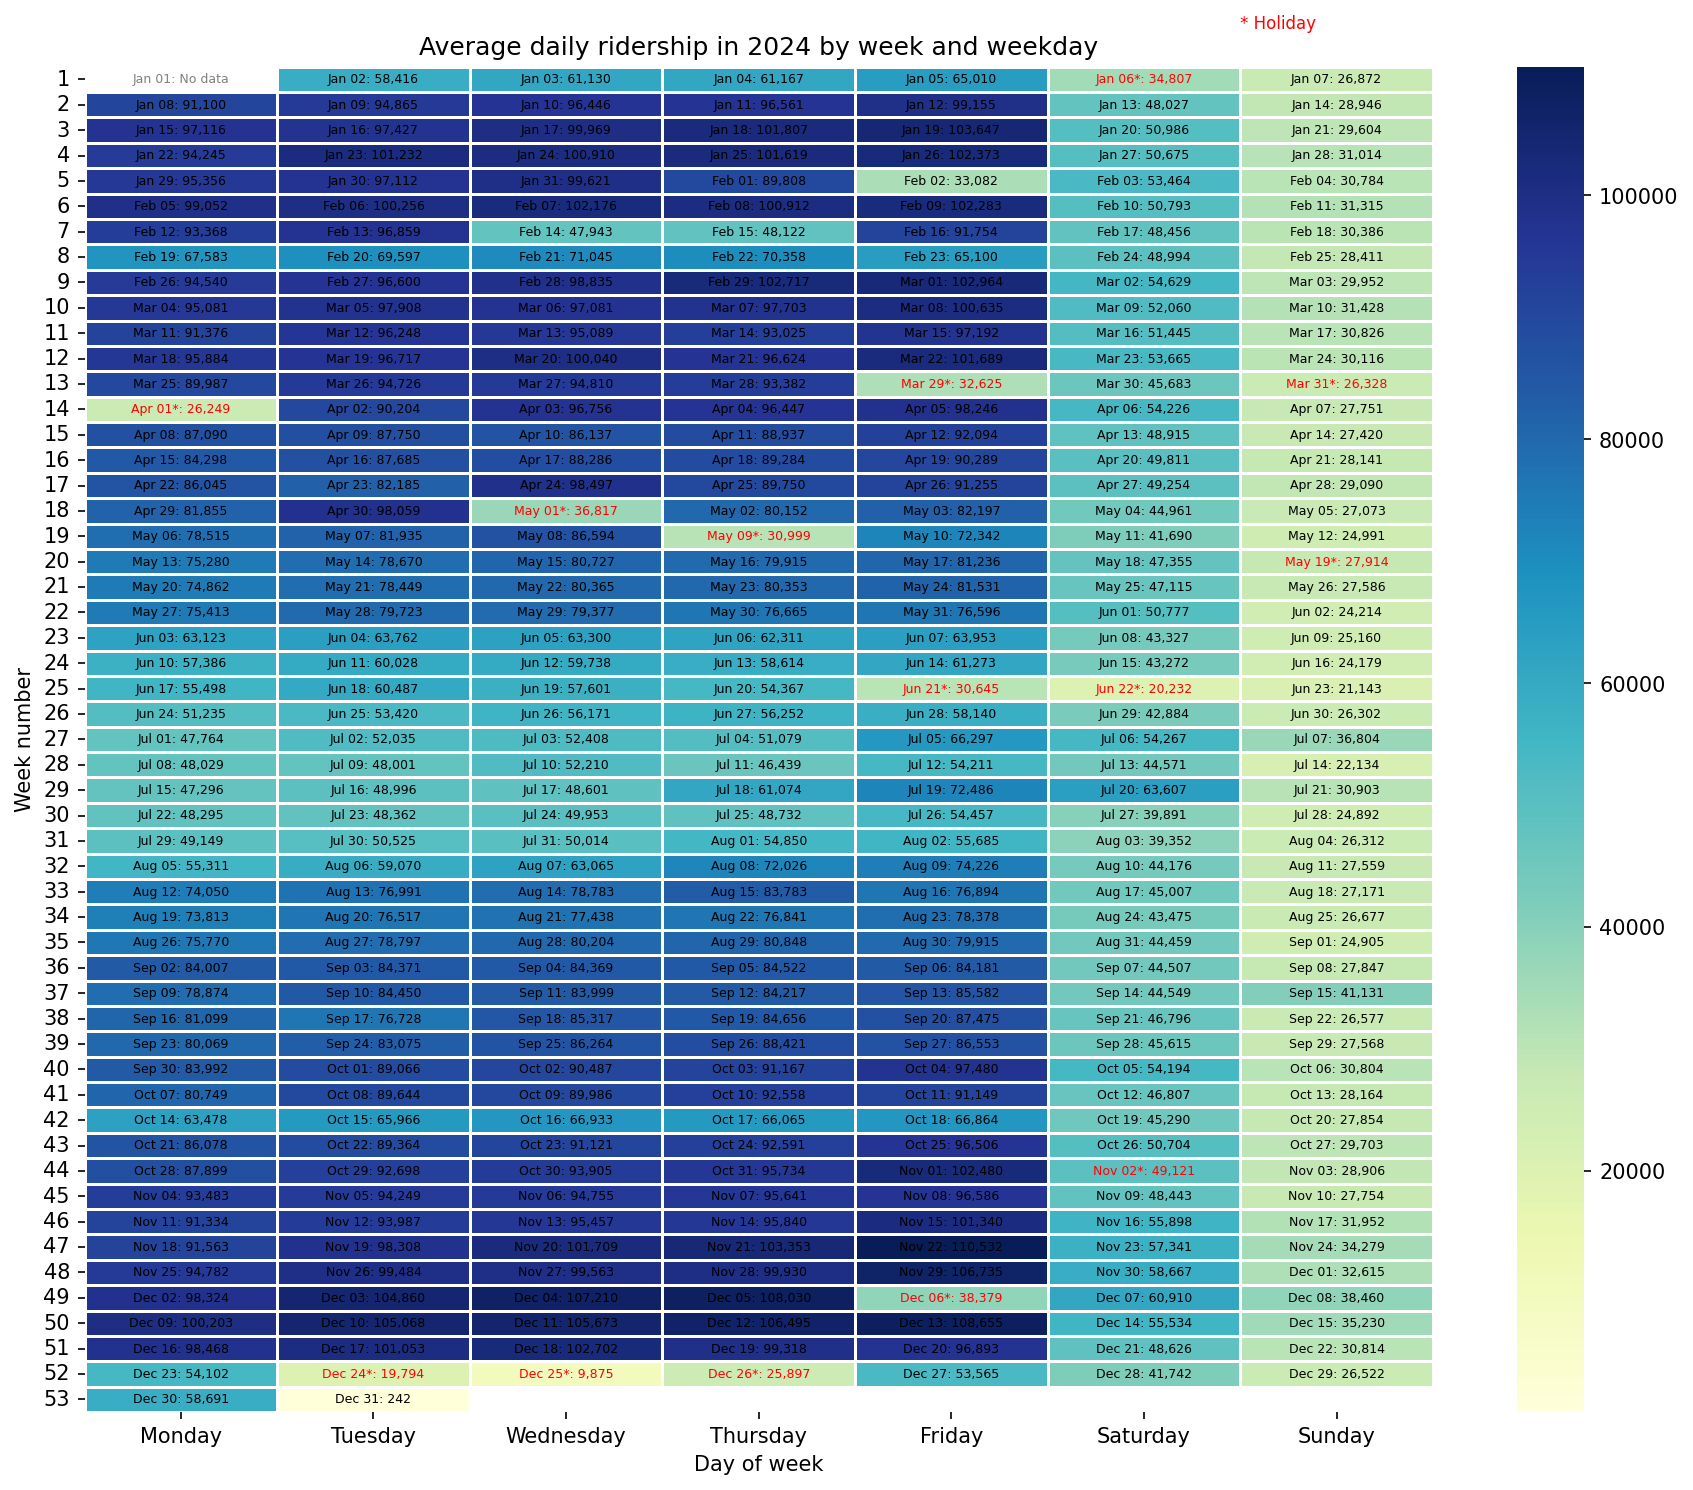

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import holidays

pass_by_date_df['date'] = pd.to_datetime(pass_by_date_df['date'])

jan1 = pd.DataFrame({
    'date': [pd.to_datetime('2024-01-01')],
    'count': [float('nan')]
})
pass_by_date_df = pd.concat([jan1, pass_by_date_df], ignore_index=True)

first_monday = pd.to_datetime('2024-01-01')
while first_monday.weekday() != 0:
    first_monday += pd.Timedelta(days=1)


pass_by_date_df['week_number'] = ((pass_by_date_df['date'] - first_monday).dt.days // 7 + 1).astype(int)

pass_by_date_df.loc[pass_by_date_df['date'] == pd.to_datetime('2024-01-01'), 'week_number'] = 0

pass_by_date_df['day_of_week'] = pass_by_date_df['date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pass_by_date_df['day_of_week'] = pd.Categorical(pass_by_date_df['day_of_week'], categories=days_order, ordered=True)

heatmap_data = pass_by_date_df.pivot_table(
    index='week_number',
    columns='day_of_week',
    values='count',
    aggfunc='mean'
)

finland_holidays = set(holidays.Finland(years=2024).keys())

plt.figure(figsize=(12, 10), dpi=150)
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',
    linewidths=0.5,
    cbar=True,
    fmt='.0f',
    mask=heatmap_data.isnull(),
    square=False,
    vmin=heatmap_data.min().min(),
    vmax=heatmap_data.max().max()
)

for y_idx, week in enumerate(heatmap_data.index):
    for x_idx, day in enumerate(heatmap_data.columns):
        try:
            if week == 0:
                date = datetime.date(2024, 1, 1)
            else:
                date = (first_monday + pd.Timedelta(weeks=week - 1, days=x_idx)).date()

            is_holiday = date in finland_holidays
            count = heatmap_data.loc[week, day]

            if pd.isna(count):
                if date == datetime.date(2024, 1, 1):
                    label = "Jan 01: No data"
                    color = 'gray'
                else:
                    continue
            else:
                date_str = date.strftime('%b %d') + ('*' if is_holiday else '')
                label = f"{date_str}: {int(round(count)):,}"
                color = 'red' if is_holiday else 'black'

            plt.text(
                x_idx + 0.5, y_idx + 0.5,
                label,
                ha='center', va='center',
                fontsize=6,
                color=color
            )
        except Exception:
            continue

plt.title('Average daily ridership in 2024 by week and weekday')
plt.ylabel('Week number')
plt.xlabel('Day of week')
plt.text(len(days_order) - 1, -1.5, '* Holiday', color='red', fontsize=8)
plt.tight_layout()
plt.show()



We will now check the average ridership on schooldays vs other workdays. 

In [121]:

school_holidays = [
    pd.date_range('2024-06-01', '2024-08-07'),  
    pd.date_range('2024-01-01', '2024-01-07'), 
    pd.date_range('2024-12-21', '2024-12-31'),  
    pd.date_range('2024-02-19', '2024-02-23'),  
    pd.date_range('2024-10-14', '2024-10-18')   
]
school_holiday_dates = pd.to_datetime(pd.concat([pd.Series(dates) for dates in school_holidays]))


finland_holidays = holidays.Finland(years=2024)
public_holiday_dates = pd.to_datetime(list(finland_holidays.keys()))


pass_by_date_df['weekday_name'] = pass_by_date_df['date'].dt.day_name()

workdays_df = pass_by_date_df[pass_by_date_df['weekday_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])].copy()

workdays_df = workdays_df[~workdays_df['date'].isin(public_holiday_dates)]

workdays_df['is_school_holiday_workday'] = workdays_df['date'].isin(school_holiday_dates)

avg_school_holiday = workdays_df.loc[workdays_df['is_school_holiday_workday'], 'count'].mean()
avg_school_day = workdays_df.loc[~workdays_df['is_school_holiday_workday'], 'count'].mean()

print(f"Average ridership on workdays during school holidays (excluding public holidays): {avg_school_holiday:,.0f}")
print(f"Average ridership on workdays outside school holidays (excluding public holidays): {avg_school_day:,.0f}")




Average ridership on workdays during school holidays (excluding public holidays): 56,713
Average ridership on workdays outside school holidays (excluding public holidays): 90,208


### Summary of Ridership Patterns and Outliers

- **Weekday ridership** remains relatively stable across all five days.
- **Saturday ridership** shows a significant drop compared to weekdays.
- **Sunday ridership** is even lower than Saturday, typically marking the lowest point of the week.
- **Public holiday ridership** (excluding Christmas) tends to resemble Sunday levels.

Pre-Christmas ridership in **December** is the highest throughout the year.

A notable drop in ridership is evident during **June and July**, which aligns with the **summer school holidays** (01.06.2024 – 07.08.2024). Other school holidays also correspond to dips in ridership:
- **Christmas holidays**: until 07.01.2024 and from 21.12.2024 onward  
- **Winter holidays**: 19.02.2024 – 23.02.2024  
- **Autumn holidays**: 14.10.2024 – 18.10.2024  

Overall ridership on school workdays is about 60% higher than on school vacation workdays.


#### Lower-than-expected ridership (outliers) and likely reasons:
- **02.02.2024** – Strike  
- **14–15.02.2024** – Strike 
- **31.12.2024** – Unusually low; likely a data error  

#### Higher-than-expected ridership (outliers) and likely reasons:
- **30.04.2024** – Vappu Eve (May Day celebrations)  
- **05–07.07.2024** – Ruisrock Festival  
- **18–21.07.2024** – Tall Ships Races in Turku  
- **15.09.2024** – Day of Turku (local city celebration)  



Let's now analyze ridership of particular routes and stops.

In [122]:
print(ext_data_2024.head(10))
print(ext_data_2024.info())
print(stops.head(10))

        date line  stop  count      stop_name  stop_lat  stop_lon zone_id  \
0 2024-01-02   99   778      5  Pansion koulu  60.44966  22.16755    FÖLI   
1 2024-01-02   99  1708      5      Katariina  60.41308  22.28881    FÖLI   
2 2024-01-02   99  1494      5      Sävelkuja  60.41913  22.30184    FÖLI   
3 2024-01-02   99   888      5  Kraatarinkatu  60.44665  22.35355    FÖLI   
4 2024-01-02   99   840      5      Jaaninoja  60.44630  22.32770    FÖLI   
5 2024-01-02   99  1513      5   Tillerinkatu  60.45817  22.17990    FÖLI   
6 2024-01-02   99   268      5      Jokipelto  60.47262  22.28634    FÖLI   
7 2024-01-02   99  1192      5   Jaaninpuisto  60.45102  22.32952    FÖLI   
8 2024-01-02   99   829      5  Kraatarinkatu  60.44752  22.35264    FÖLI   
9 2024-01-02   99  1511      5  Paavolanaukio  60.45697  22.17405    FÖLI   

     stop_timezone stop_name_filled      day day_type  
0  Europe/Helsinki    Pansion koulu  Tuesday  Workday  
1  Europe/Helsinki        Katariina  Tue

We will now analyze ridership by stop and by route.

## Ridership by stop

First we group by the stop.

In [123]:
stop_rid = ext_data_2024.groupby("stop")["count"].sum()
stop_rid_df = stop_rid.reset_index()
stop_data =  stop_rid_df.merge(stops, how='left', left_on='stop', right_on='stop_id')
stop_data.drop(columns="stop_id", inplace=True)
print(stop_rid_df.head())
print(stop_data.head())



   stop   count
0     1   47879
1     2  101917
2     3   15266
3     4   72947
4     5   53016
   stop   count              stop_name  stop_lat  stop_lon zone_id  \
0     1   47879   Turun satama (Silja)  60.43497  22.21966    FÖLI   
1     2  101917  Turun satama (Viking)  60.43405  22.22181    FÖLI   
2     3   15266             Satamakatu  60.43567  22.22523    FÖLI   
3     4   72947            Turun linna  60.43569  22.23012    FÖLI   
4     5   53016          Forum Marinum  60.43725  22.23518    FÖLI   

     stop_timezone  
0  Europe/Helsinki  
1  Europe/Helsinki  
2  Europe/Helsinki  
3  Europe/Helsinki  
4  Europe/Helsinki  


Now we find the busiest and quietest stops.

In [124]:
stop_top =  stop_data.sort_values(by='count', ascending=False).head(10)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]
stop_top_reset.columns = ['Stop', 'Stop name', 'Rides', 'Stop latitude', 'Stop longitude']
print("Ten busiest stops in 2024:")
display(stop_top_reset.style.hide(axis="index"))



Ten busiest stops in 2024:


Stop,Stop name,Rides,Stop latitude,Stop longitude
1933,Kauppatori D3,432252,60.450900,22.266240
1903,Kauppatori A3,420709,60.451040,22.266350
1901,Kauppatori A1,418907,60.451680,22.265460
1931,Kauppatori D1,387306,60.451520,22.265340
1904,Kauppatori A4,370056,60.450850,22.266810
1914,Kauppatori B4,350742,60.450850,22.267120
1934,Kauppatori D4,337888,60.450300,22.265380
1917,Kauppatori B7,328271,60.451340,22.268710
16,Brahenkatu,318539,60.452450,22.272090
1924,Kauppatori C4,292486,60.450490,22.266360


We see that 9 out of 10 most popular stops are in the Market Square (Kauppatori), and the remaining one (Brahenkatu) is also close by in the city center.

Let us plot the busiest stops on a map.

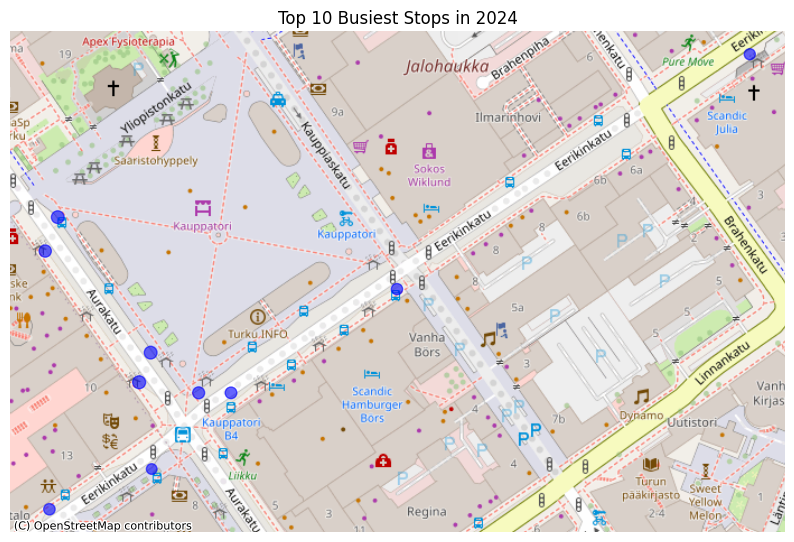

In [125]:
stop_top =  stop_data.sort_values(by='count', ascending=False).head(10)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]

import geopandas as gpd
from shapely.geometry import Point
stop_top_gdf = gpd.GeoDataFrame(
    stop_top_reset, 
    geometry=[Point(xy) for xy in zip(stop_top_reset['stop_lon'], stop_top_reset['stop_lat'])],
    crs="EPSG:4326" 
)
stop_top_gdf = stop_top_gdf.to_crs(epsg=3857)


import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

stop_top_gdf.plot(ax=ax, 
               markersize=stop_top_gdf['count'] / 5000,  
               color='blue', 
               alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Top 10 Busiest Stops in 2024")
plt.axis('off') 
plt.show()



Here is an interactive map of the top 50 stops by ridership, ignoring stops with missing data (saved as an html file stop_map.html).

In [126]:
import folium

stop_data_2 = stop_data[stop_data['stop_lat'].notna() & stop_data['stop_lon'].notna()]
stop_top =  stop_data_2.sort_values(by='count', ascending=False).head(50)
stop_top_reset = stop_top.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]

m = folium.Map(location=[stop_top_reset['stop_lat'].mean(),
                         stop_top_reset['stop_lon'].mean()],
               zoom_start=13)


max_count = stop_top_reset['count'].max()
min_radius = 1
max_radius = 20

for _, row in stop_top_reset.iterrows():

    radius = min_radius + (row['count'] / max_count) * (max_radius - min_radius)
    
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=radius,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['stop_name']}: {row['count']} rides"
    ).add_to(m)


    m.save("stop_map.html")



We see that there is a big cluster of high ridership stops in Turku city center (around Market square and by the Cathedral), as well as a cluster around Kupittaa station (where trains from Helsinki terminated in 2024) and in the Varissuo neighnourhood in Eastern Turku. There are also high ridership stops in Runosmäki neighbourhood in Northern Turku, by the Turku bus station, Turku passenger harbour, Turku shipyard, towns of Raisio and Naantali (outside of Turku but covered by the bus system), by Mylly shopping mall and Kupittaa ice hockey arena.

Here we see only 8 stops. First and third most popular stops were on the RUIS festival bus route, as checked below, and their coordinates are not in the table we downloaded.

In [127]:
stops_ruis = ext_data_2024[ext_data_2024["line"] == "RUIS"]
print(stops_ruis["stop"].unique())

[1979 1978]


We now look at the quietest stops.

In [128]:
stop_bottom =  stop_data.sort_values(by='count', ascending=True).head(10)
stop_bottom_reset = stop_bottom.reset_index()[['stop', 'stop_name', 'count', 'stop_lat', 'stop_lon']]
stop_bottom_reset.columns = ['Stop', 'Stop name', 'Rides', 'Stop latitude', 'Stop longitude']
display(stop_bottom_reset.style.hide(axis="index"))



Stop,Stop name,Rides,Stop latitude,Stop longitude
7190,Korvenalantie,5,60.481120,22.784460
8845,Vällintie P,5,60.712550,22.443460
2109,Kerrola,5,60.478120,22.149640
2048,Lampitie,5,60.483620,22.098560
1818,Vitanovantie,5,60.378360,22.219940
1725,Pampinkatu,5,60.414040,22.244040
1842,Tuomiokirkkotori,5,60.451720,22.275920
1766,Aatilanhaka,5,60.353720,22.258060
3050,Horjantie,5,60.466080,21.879580
1463,Sorakatu,5,60.426980,22.316300


This looks odd, let's look at riderships on that stops at particular days.

In [129]:
print(ext_data_2024[ext_data_2024['stop'].isin(stop_bottom_reset['Stop'])])

             date  line  stop  count         stop_name  stop_lat  stop_lon  \
18     2024-01-02   221  1463      5          Sorakatu  60.42698  22.31630   
157937 2024-03-12   206  2109      5           Kerrola  60.47812  22.14964   
320533 2024-05-24    N8  3050      5         Horjantie  60.46608  21.87958   
416603 2024-07-20   15A  1766      5       Aatilanhaka  60.35372  22.25806   
445230 2024-08-07  722S  1842      5  Tuomiokirkkotori  60.45172  22.27592   
467175 2024-08-17    23  8845      5       Vällintie P  60.71255  22.44346   
482456 2024-08-24    51  1725      5        Pampinkatu  60.41404  22.24404   
500541 2024-09-02    R1  2048      5          Lampitie  60.48362  22.09856   
628564 2024-10-29   PA6  7190      5     Korvenalantie  60.48112  22.78446   
768915 2024-12-28   15A  1818      5      Vitanovantie  60.37836  22.21994   

       zone_id    stop_timezone  stop_name_filled        day day_type  
18        FÖLI  Europe/Helsinki          Sorakatu    Tuesday  Workday

We see that each of these stops has ridership only from one day. Since it doesn't look like trustworthy data, we will omit stops which have ridership from less than 50 days throughout the year. They might be some temporary stops, or there might be some mistake in data collection. 

Also it looks like there is no data from stops where there were less than 5 rides on particular day, or perhaps when the number of rides is less than 6 it got replaced by 5.

In [130]:
for i in range(1, 11):
    print(f"Number of stops with {i} passengers per year recorded is {len(stop_data[stop_data['count'] == i])}")


Number of stops with 1 passengers per year recorded is 0
Number of stops with 2 passengers per year recorded is 0
Number of stops with 3 passengers per year recorded is 0
Number of stops with 4 passengers per year recorded is 0
Number of stops with 5 passengers per year recorded is 98
Number of stops with 6 passengers per year recorded is 34
Number of stops with 7 passengers per year recorded is 21
Number of stops with 8 passengers per year recorded is 19
Number of stops with 9 passengers per year recorded is 8
Number of stops with 10 passengers per year recorded is 29


## Ridership by line

We now group by line.

In [131]:
line_rid = ext_data_2024.groupby("line")["count"].sum()
line_data = line_rid.reset_index()
print(line_data)

    line    count
0      1  1065482
1    100    44281
2     12  1077844
3    12T     3582
4     13   357980
..   ...      ...
182   V1     5057
183   V2     1415
184   V3     4320
185   V4      382
186   V5     3394

[187 rows x 2 columns]


Let us first find the most popular bus line.

In [132]:
top_line_index = line_data["count"].idxmax()
print(f"The most popular line in 2024 was line {line_data.iloc[top_line_index]["line"]}.")


The most popular line in 2024 was line 18.


Let's look in more detail at line 18 ridership. 
(Note that in 2025 the bus system in Turku changed substantially and that line basically became line 8.)

We first look at the stops along the line and boarding numbers.


In [133]:
ext_data_line_18 = ext_data_2024[ext_data_2024['line'] == '18']
stops_line_18 = ext_data_line_18.groupby("stop")["count"].sum().reset_index()
stops_line_18_data = stops_line_18.merge(stops, how='left', left_on='stop', right_on='stop_id')


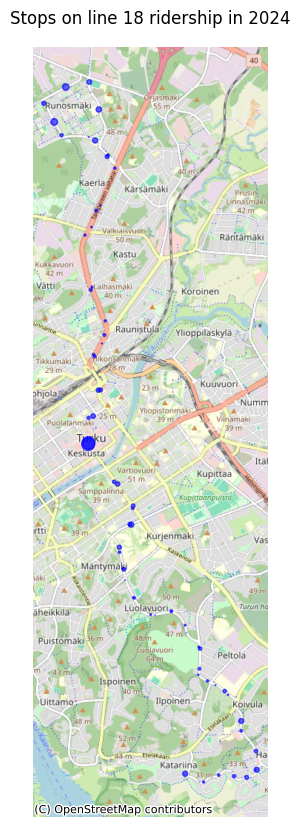

In [134]:


import geopandas as gpd
from shapely.geometry import Point
stops_line_18_gdf = gpd.GeoDataFrame(
    stops_line_18_data, 
    geometry=[Point(xy) for xy in zip(stops_line_18_data['stop_lon'], stops_line_18_data['stop_lat'])],
    crs="EPSG:4326"  # WGS84 latitude/longitude
)
stops_line_18_gdf = stops_line_18_gdf.to_crs(epsg=3857)


import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

stops_line_18_gdf.plot(ax=ax, 
               markersize=stops_line_18_gdf['count'] / 5000, 
               color='blue', 
               alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Stops on line 18 ridership in 2024")
plt.axis('off')  
plt.show()


An interactive map is saved as stop_map_line_18.html

In [135]:
import folium


m = folium.Map(location=[stop_data_2['stop_lat'].mean(),
                         stop_data_2['stop_lon'].mean()],
               zoom_start=13)


scale_factor = 50

for _, row in stops_line_18_gdf.iterrows():
    
    folium.CircleMarker(
    location=[row['stop_lat'], row['stop_lon']],
    radius=max(1, (row['count'] ** 0.5) / scale_factor),
    popup=f"{row['stop_name']} ({row['count']} rides)",
    color='blue',
    fill=True,
    fill_opacity=0.6
).add_to(m)

    m.save("stop_map_line_18.html")


Let's look at the total ridership of line 18 in 2024 and compare it to the ridership in the whole system in 2024.

In [136]:
total_passengers = ext_data_2024['count'].sum()
print(f"The total number of trips in 2024: {total_passengers :,}")

pass_total_line_18 = ext_data_line_18["count"].sum()
prop_line_18 = pass_total_line_18 / total_passengers * 100
print(f"The total number of trips on line 18 in 2024: {pass_total_line_18:,}, which is around \
{prop_line_18:.1f}% of the total number of trips in the system.")


The total number of trips in 2024: 24,807,995
The total number of trips on line 18 in 2024: 2,535,511, which is around 10.2% of the total number of trips in the system.


Let's check the days with maximum ridership for line 18 and compare with general ridership in the system.

In [137]:
pass_by_date_line_18 = ext_data_line_18.groupby("date")["count"].sum().reset_index()
pass_by_date_line_18_top = pass_by_date_line_18.sort_values(by="count", ascending=False).head(5)
pass_by_date_line_18_top = pass_by_date_line_18_top.reset_index(drop=True)
pass_by_date_line_18_top.columns = ['Date', 'Rides']
pass_by_date_line_18_top['Date'] = pd.to_datetime(pass_by_date_line_18_top['Date'])
print("Five busiest days for line 18:")
display(pass_by_date_line_18_top.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))

pass_top =  pass_by_date.sort_values(ascending=False).head()
pass_top_reset = pass_top.reset_index()
pass_top_reset.columns = ['Date', 'Rides']
print("Five busiest days for the whole system:")
display(pass_top_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))






Five busiest days for line 18:


Date,Rides
2024-12-04,"10,890"
2024-11-22,"10,839"
2024-12-03,"10,765"
2024-12-13,"10,648"
2024-12-11,"10,639"


Five busiest days for the whole system:


Date,Rides
2024-11-22,"110,532"
2024-12-13,"108,655"
2024-12-05,"108,030"
2024-12-04,"107,210"
2024-11-29,"106,735"


We see that, although there is a slight difference with precise dates, it is still similar to general trends, with highest ridership in the end of the year before Christmas.

Let's look at the lowest ridership days.

In [138]:
pass_by_date_line_18 = ext_data_line_18.groupby("date")["count"].sum().reset_index()
pass_by_date_line_18_bottom = pass_by_date_line_18.sort_values(by="count", ascending=True).head(5)
pass_by_date_line_18_bottom = pass_by_date_line_18_bottom.reset_index(drop=True)
pass_by_date_line_18_bottom.columns = ['Date', 'Rides']
pass_by_date_line_18_bottom['Date'] = pd.to_datetime(pass_by_date_line_18_bottom['Date'])
print("Five quietest days for line 18:")
display(pass_by_date_line_18_bottom.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))

pass_bottom =  pass_by_date.sort_values(ascending=True).head()
pass_bottom_reset = pass_bottom.reset_index()
pass_bottom_reset.columns = ['Date', 'Rides']
print("Five quietest days for the whole system:")
display(pass_bottom_reset.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}"
}))


Five quietest days for line 18:


Date,Rides
2024-12-31,13
2024-12-25,"1,382"
2024-06-22,"2,120"
2024-06-23,"2,335"
2024-07-14,"2,471"


Five quietest days for the whole system:


Date,Rides
2024-12-31,242
2024-12-25,"9,875"
2024-12-24,"19,794"
2024-06-22,"20,232"
2024-06-23,"21,143"


Again, data for 31.12 seems wrong, while other trends seem similar for line 18 and the whole system.


Let's now look when the proportion of line 18 ridership to total ridership is the smallest.

In [139]:
pass_by_date_line_18 = ext_data_line_18.groupby("date")["count"].sum().reset_index()
pass_by_date = ext_data_2024.groupby('date')['count'].sum().reset_index()
pass_by_date_line_18["prop_to_all"] = pass_by_date_line_18["count"] / pass_by_date["count"]


pass_by_date_line_18_diff_bottom = pass_by_date_line_18.sort_values(by="prop_to_all", ascending=True).head(5)
pass_by_date_line_18_diff_bottom = pass_by_date_line_18_diff_bottom.reset_index(drop=True)
pass_by_date_line_18_diff_bottom.columns = ['Date', 'Rides', 'Proportion']
pass_by_date_line_18_diff_bottom['Date'] = pd.to_datetime(pass_by_date_line_18_diff_bottom['Date'])
print("Five days with lowest proportion of rides on line 18 to all rides:")
display(pass_by_date_line_18_diff_bottom.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}",
    "Proportion": "{:.3f}"
}))






Five days with lowest proportion of rides on line 18 to all rides:


Date,Rides,Proportion
2024-12-31,13,0.054
2024-07-07,"2,568",0.070
2024-07-06,"3,831",0.071
2024-07-20,"5,059",0.080
2024-07-05,"5,695",0.086


Apart from Dec. 31st (data error), we get Ruisrock Festival days (05.07-07.07) and one of the Tall Ships Race in Turku days (20.07), those two latter probably due to the fact that bus route 18 was not relevant for those events' locations. We will come back to route riderships on those special days later.

Let's now look when the proportion of line 18 ridership to total ridership is the highest.

In [140]:
pass_by_date_line_18_diff_top = pass_by_date_line_18.sort_values(by="prop_to_all", ascending=False).head(5)
pass_by_date_line_18_diff_top = pass_by_date_line_18_diff_top.reset_index(drop=True)
pass_by_date_line_18_diff_top.columns = ['Date', 'Rides', 'Proportion']
pass_by_date_line_18_diff_top['Date'] = pd.to_datetime(pass_by_date_line_18_diff_top['Date'])
print("Five days with highest proportion of rides on line 18 to all rides:")
display(pass_by_date_line_18_diff_top.style.hide(axis="index").format({
    "Date": lambda d: d.strftime('%Y-%m-%d'),
    "Rides": "{:,}",
    "Proportion": "{:.3f}"
}))


Five days with highest proportion of rides on line 18 to all rides:


Date,Rides,Proportion
2024-02-02,"5,920",0.179
2024-02-14,"7,429",0.155
2024-02-15,"7,308",0.152
2024-12-25,"1,382",0.140
2024-12-24,"2,472",0.125


The first three days are strike days, so probably line 18 was running a more regular service on those days than some other lines. Also on Christmas Day and Christmas Eve line 18 was particularly popular.

Let us now compare line riderships, both total and on individual days. We first look at the most popular bus lines.

In [141]:
top_lines = line_data.sort_values(by="count", ascending=False).head(10)
top_lines = top_lines.reset_index(drop=True)
display(top_lines.style.hide(axis="index"))


line,count
18,2535511
42,1537088
32,1470478
7,1385732
6,1345983
9,1188489
12,1077844
1,1065482
60,957577
300,871127


Let's visualize line ridership with a bar plot.

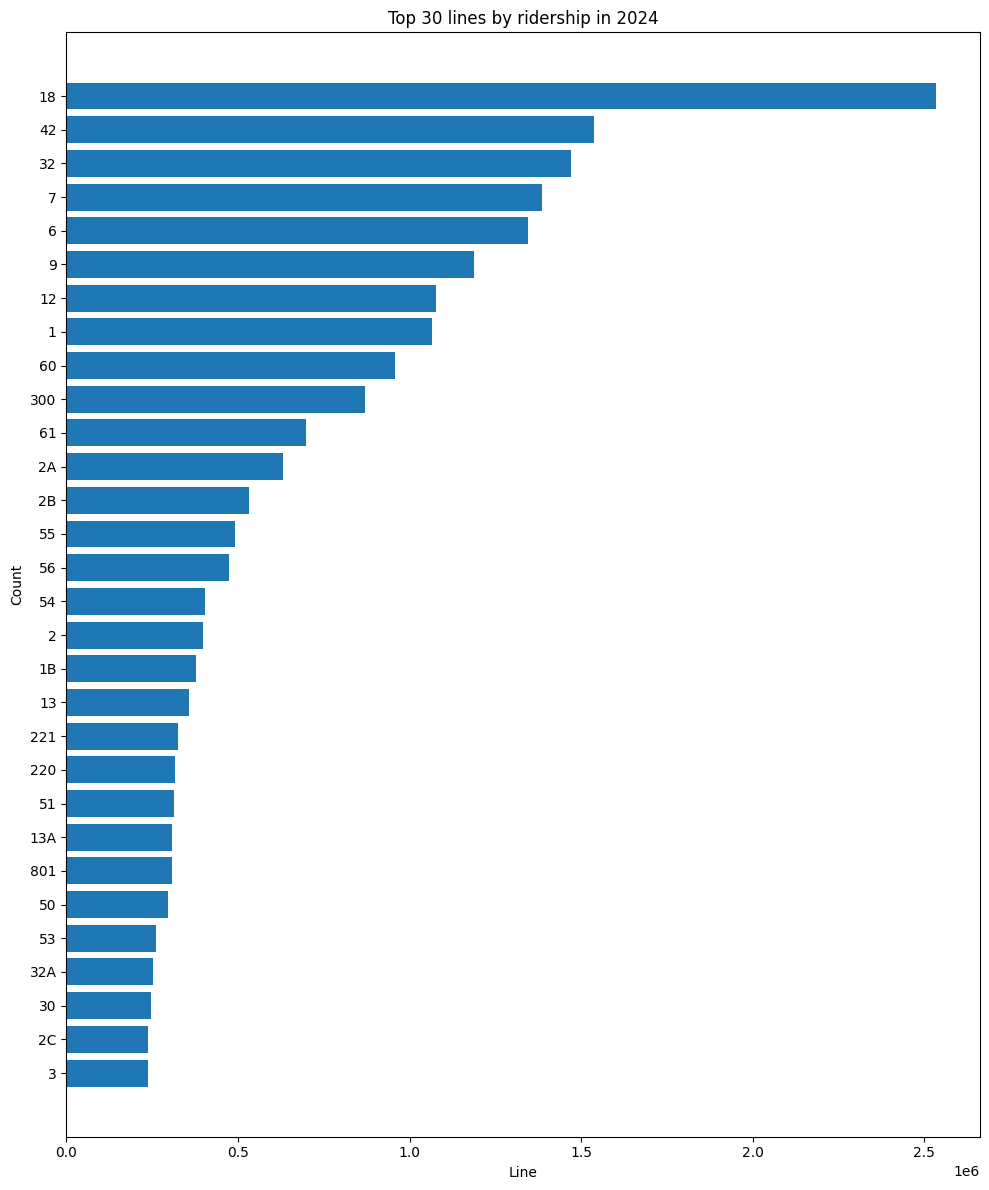

In [142]:
lines_sorted = line_data.sort_values(by="count", ascending=False)
lines_sorted_top = lines_sorted.head(30)

plt.figure(figsize=(10, 12))
plt.barh(lines_sorted_top["line"], lines_sorted_top["count"])
plt.xlabel("Line")
plt.ylabel("Count")
plt.title("Top 30 lines by ridership in 2024")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()